# ___

# [ Machine Learning in Earth Observation and Geography ]

</br>


<div>
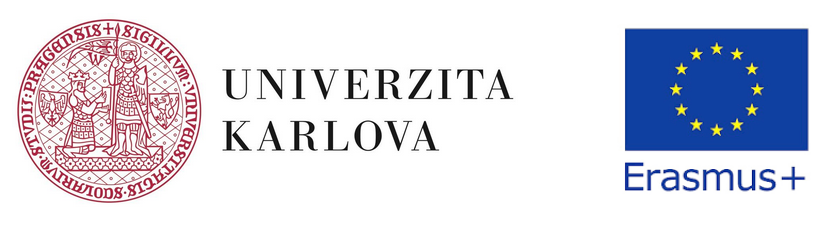
</div>

---

Lecturer: *Lukas Brodsky lukas.brodsky@natur.cuni.cz*

**Department of Applied Geoinformatics and Carthography, Charles University** 

___


### 1.1 The Problem

TASK: Predict Forest Fires using Meteorological Data

Context: "Forest fires are a major environmental issue, creating economical and ecological damage while endangering human lives. Fast detection is a key element for controlling such phenomenon. To achieve this, one alternative is to use automatic tools based on local sensors, such as provided by meteorological stations. In effect, meteorological conditions (e.g. temperature, wind) are known to influence forest fires and several fire indexes, such as the forest Fire Weather Index (FWI), you can use such features, see below the figure for feature engineering. 
In this work, we explore a Machine Learning (ML) approach to **predict the burned area of forest fires**.


### 1.2 Assumptions

* The problem is a multivariate regression (will use multiple features to make a prediction); 
* There is no continuous flow of data, hence batch learning shall be applied; 
* The meterological data are good indicators of the forest fire; 
* There are enough variables (features) to predict the forest fire. 


### 1.3 Expected results 

* Machine Learning model to predict the burned area of the forest fires based on the meterological data. 
___    

### Weather features

<div>
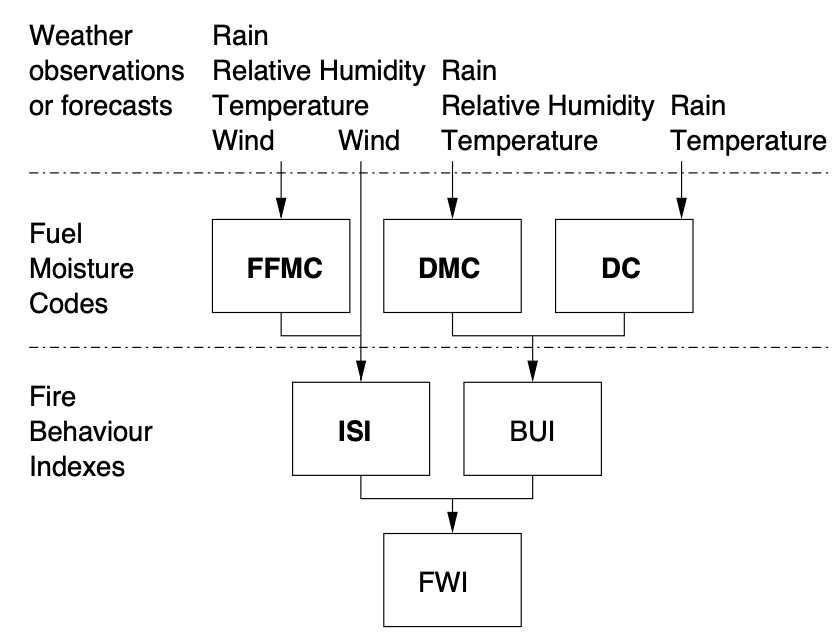
</div>

### Abbreviation 

    FWI .. Fire Weather Index
    FFMC .. Fine Fuel Moisture Code
    DMC .. Duff Moisture Code 
    DC .. Drought Code 
    ISI .. Initial Spread Index 
    BUI .. Buildup Index

more in Paulo Cortez and Anıbal Morais (2007) 

### Input data atrributes description

**Attribute information**

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 


### Setup environment

In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from math import sqrt
from numpy import mean, absolute
from sklearn.model_selection import GridSearchCV 

# plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Input data

In [2]:
# check the data set dir 
forest_path = os.path.join('./', "forest_fires")
print(os.listdir(forest_path))

['forestfires.names', 'forestfires.csv']


In [3]:
# function to read the csv file 
def load_local_data(data_path, csv_file):
    csv_path = os.path.join(data_path, csv_file)
    return pd.read_csv(csv_path)

In [4]:
# load data 
fires = load_local_data(forest_path, "forestfires.csv")

# check header and some values 
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## 2. Exploratory data analysis 

### 2.1 Plot the data

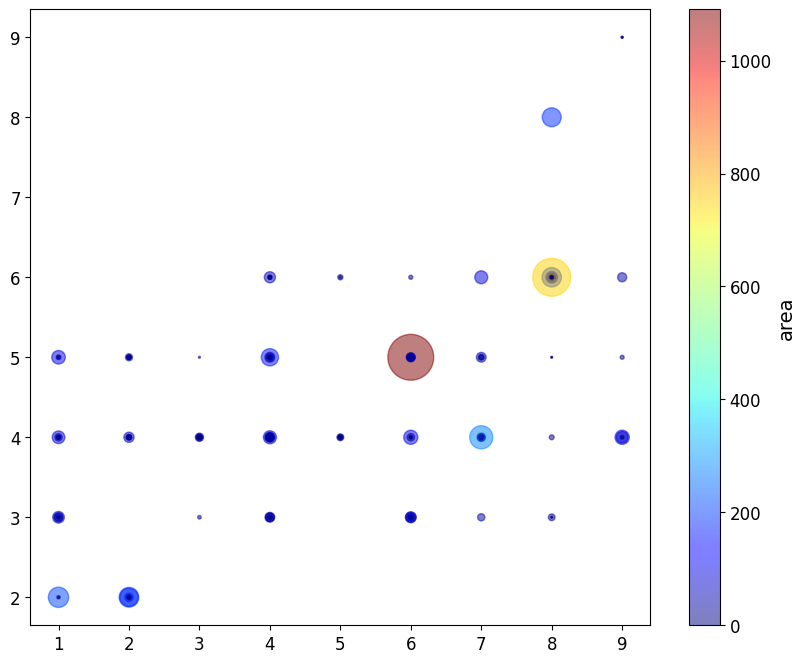

In [6]:
# 2.1 Visualize the map
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(fires['X'], fires['Y'], 
            c=fires['area'], s=fires['area'], 
            cmap="jet", alpha=0.5)

plt.colorbar(label="area")

In [7]:
fires.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

### 2.2 Any correlations?  

array([[<Axes: xlabel='temp', ylabel='temp'>,
        <Axes: xlabel='DMC', ylabel='temp'>,
        <Axes: xlabel='DC', ylabel='temp'>,
        <Axes: xlabel='area', ylabel='temp'>],
       [<Axes: xlabel='temp', ylabel='DMC'>,
        <Axes: xlabel='DMC', ylabel='DMC'>,
        <Axes: xlabel='DC', ylabel='DMC'>,
        <Axes: xlabel='area', ylabel='DMC'>],
       [<Axes: xlabel='temp', ylabel='DC'>,
        <Axes: xlabel='DMC', ylabel='DC'>,
        <Axes: xlabel='DC', ylabel='DC'>,
        <Axes: xlabel='area', ylabel='DC'>],
       [<Axes: xlabel='temp', ylabel='area'>,
        <Axes: xlabel='DMC', ylabel='area'>,
        <Axes: xlabel='DC', ylabel='area'>,
        <Axes: xlabel='area', ylabel='area'>]], dtype=object)

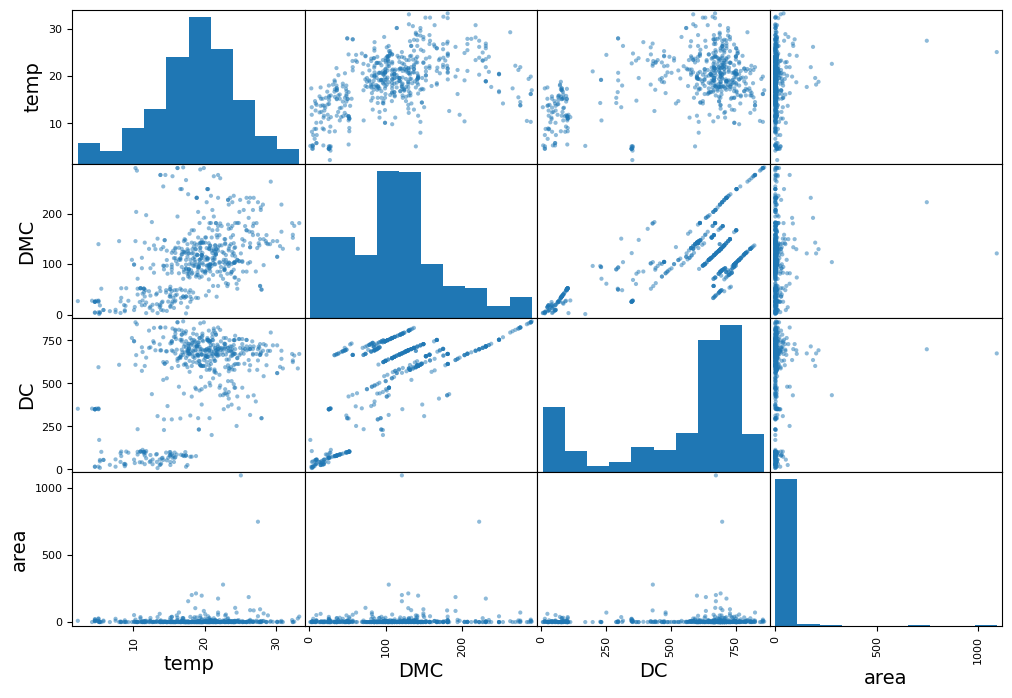

In [8]:
attributes = ["temp", "DMC", "DC",
              "area"]
scatter_matrix(fires[attributes], figsize=(12, 8), alpha=0.5)

In [9]:
# Linear correlations? 
attributes2 = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", 
              "area"]
corr_matrix = fires[attributes2].corr() 
corr_matrix["area"].sort_values(ascending=False) 

area    1.000000
temp    0.097844
DMC     0.072994
DC      0.049383
FFMC    0.040122
wind    0.012317
ISI     0.008258
rain   -0.007366
RH     -0.075519
Name: area, dtype: float64

<Axes: xlabel='temp', ylabel='DMC'>

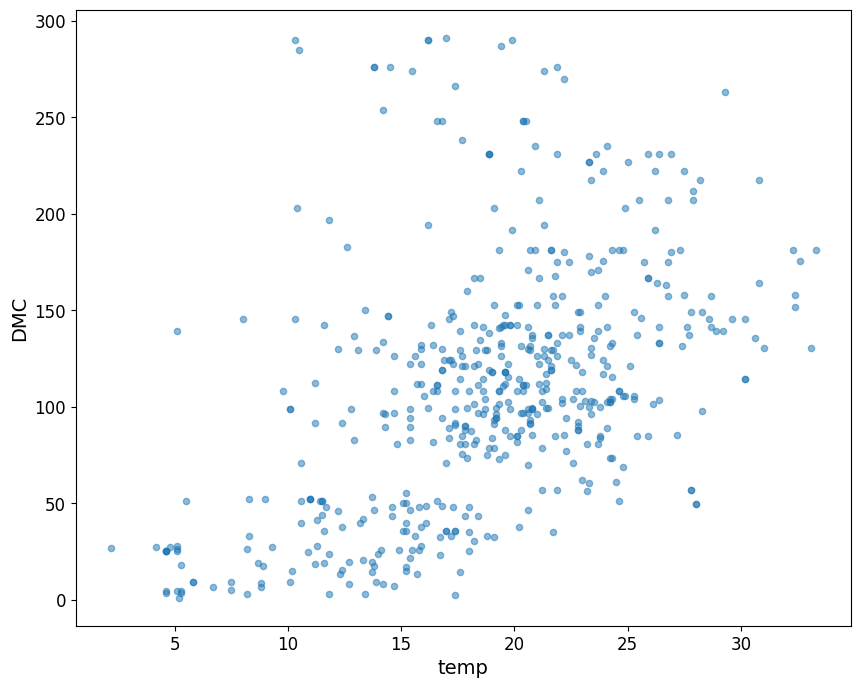

In [10]:
# Scatterplot 
fires.plot(kind="scatter", x="temp", y="DMC", alpha=0.5)

### 2.3 Explore the variables

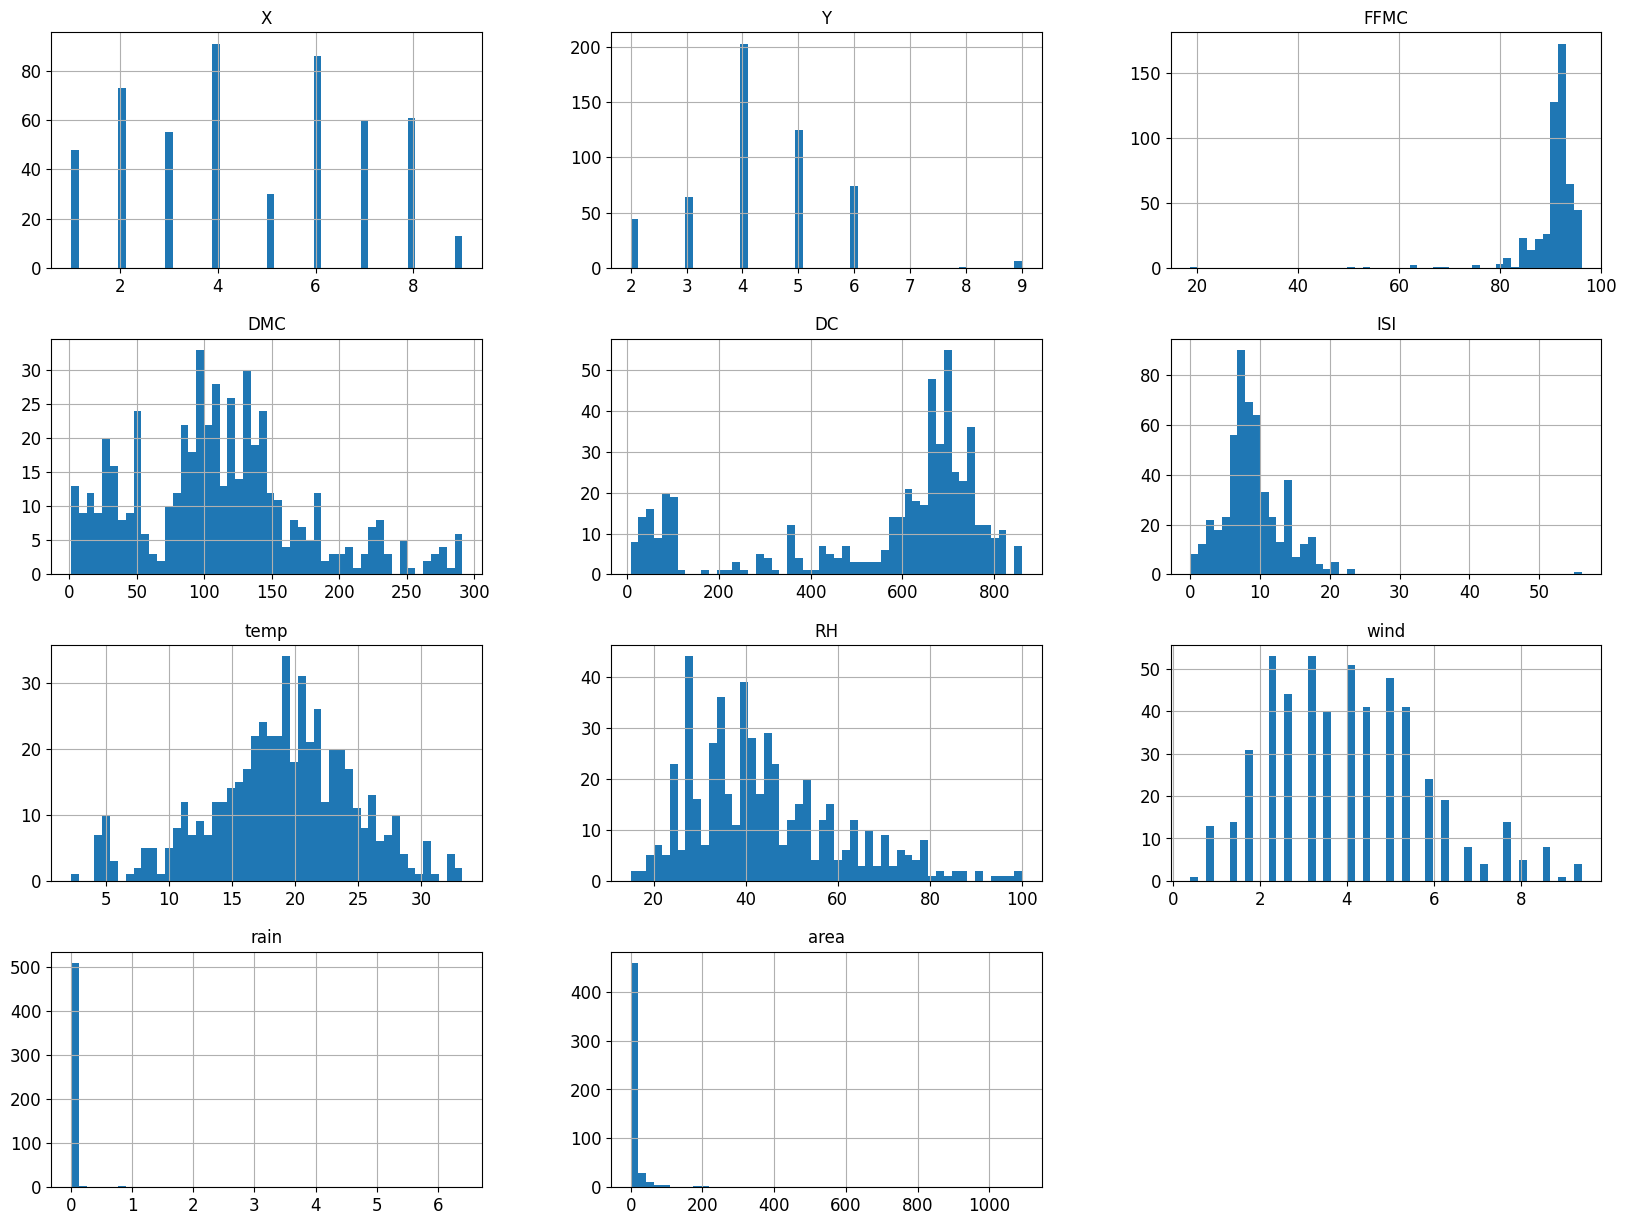

In [11]:
fires.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

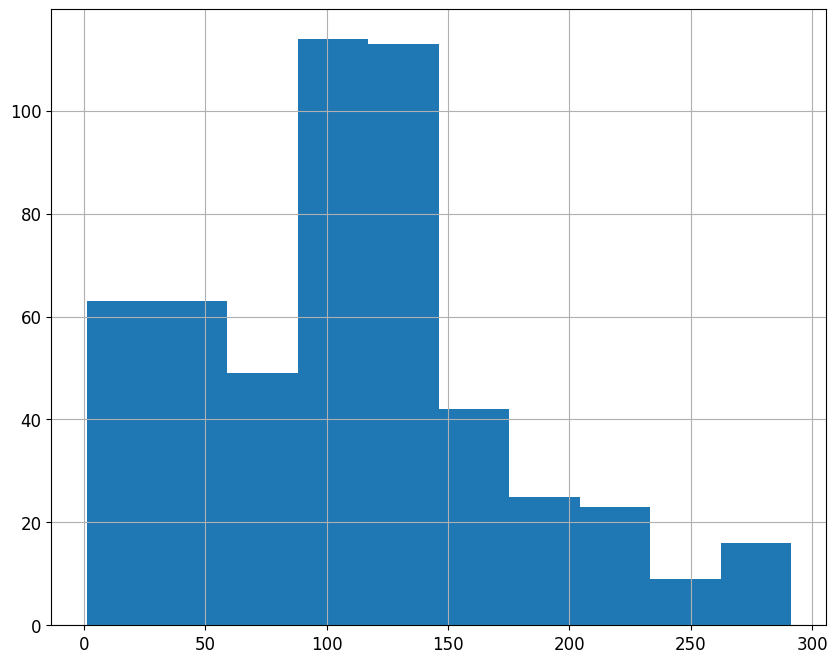

In [12]:
# Check the DMC histogram 
fires["DMC"].hist()

In [13]:
fires[fires['area'] > 0]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29


In [14]:
fires.shape

(517, 13)

## 2. Data Preparation

### 3.1 Feature engineering 

In [15]:
# encoding month
enc = OrdinalEncoder()

In [16]:
# enc = OrdinalEncoder()
enc.fit(fires[["month"]])

OrdinalEncoder()

In [17]:
# New feature
fires[["month_ord"]] = enc.transform(fires[["month"]])

In [38]:
fires.describe

<bound method NDFrame.describe of      X  Y  FFMC    DMC     DC   ISI  temp  RH  wind  rain  month_ord
0    7  5  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0        7.0
1    7  4  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0       10.0
2    7  4  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0       10.0
3    8  6  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2        7.0
4    8  6  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0        7.0
..  .. ..   ...    ...    ...   ...   ...  ..   ...   ...        ...
512  4  3  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0        1.0
513  2  4  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0        1.0
514  7  4  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0        1.0
515  1  4  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0        1.0
516  6  3  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0        9.0

[517 rows x 11 columns]>

In [19]:
fires.head(20)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_ord
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,7.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,10.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,10.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,7.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,7.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0,1.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0,1.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0,1.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0,11.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0,11.0


In [23]:
np.unique(fires[["month"]])

array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object)

In [26]:
# 3.2 Any no-data values (NaNs)? 
fires.isnull().any() 

X            False
Y            False
month        False
day          False
FFMC         False
DMC          False
DC           False
ISI          False
temp         False
RH           False
wind         False
rain         False
area         False
month_ord    False
dtype: bool

### 3.2 Fill-in meadian value 

In [ ]:
# median = df["temp"].median()
# sample_incomplete_rows["temp"].fillna(median, inplace=True) 
# sample_incomplete_rows

In [ ]:
# Better to use geostatistics! ... modelling also spatial dependencies! 

#### OR Reject records with missing value

In [ ]:
# df.dropna(subset=["temp"])

### 3.3 Harmonize data 

In [ ]:
# scale feature values 

In [27]:
from sklearn.preprocessing import StandardScaler
data = [[0, 0], [0, 0], [1, 1], [1, 1]]

In [28]:
data

[[0, 0], [0, 0], [1, 1], [1, 1]]

In [29]:
scaler = StandardScaler()
scaler.fit(data)
print(scaler.mean_)

[0.5 0.5]


In [30]:
scaled_data = scaler.transform(data)
scaled_data

array([[-1., -1.],
       [-1., -1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [31]:
scaler.inverse_transform(scaled_data, copy=None)

array([[0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.]])

In [32]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_ord
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,7.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,10.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,10.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,7.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,7.0


In [33]:
fires.drop("month", inplace=True, axis=1)
fires.drop("day", inplace=True, axis=1)

In [34]:
y = fires['area']

In [35]:
fires.drop("area", inplace=True, axis=1)

In [36]:
ff_scaler = StandardScaler()
ff_scaler.fit(fires)

StandardScaler()

In [37]:
fires_scaled = ff_scaler.transform(fires)
fires_scaled

array([[ 1.00831277,  0.56986043, -0.80595947, ...,  1.49861442,
        -0.07326831,  0.28422225],
       [ 1.00831277, -0.24400101, -0.00810203, ..., -1.74175564,
        -0.07326831,  0.97087134],
       [ 1.00831277, -0.24400101, -0.00810203, ..., -1.51828184,
        -0.07326831,  0.97087134],
       ...,
       [ 1.00831277, -0.24400101, -1.64008316, ...,  1.49861442,
        -0.07326831, -1.08907592],
       [-1.58736044, -0.24400101,  0.68095666, ..., -0.00983371,
        -0.07326831, -1.08907592],
       [ 0.57570057, -1.05786246, -2.02087875, ...,  0.26950853,
        -0.07326831,  0.74198831]])

In [40]:
type(fires_scaled)

numpy.ndarray

In [41]:
fires_scaled_df = pd.DataFrame(fires_scaled, columns=fires.columns)
fires_scaled_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_ord
0,1.008313,0.569860,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,0.284222
1,1.008313,-0.244001,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,0.970871
2,1.008313,-0.244001,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,0.970871
3,1.440925,1.383722,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,0.284222
4,1.440925,1.383722,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,0.284222


### 3.4 Split train/test 

In [81]:
fires_scaled_df.drop('wind', inplace=True, axis=1)

In [82]:
fires_scaled_df.drop('rain', inplace=True, axis=1)

In [85]:
fires_scaled_df.drop('month_ord', inplace=True, axis=1)

In [86]:
fires_scaled_df.drop('X', inplace=True, axis=1)

In [87]:
fires_scaled_df.drop('Y', inplace=True, axis=1)

In [88]:
X = fires_scaled_df.copy()
# X = fires.copy()
# X.drop("area", inplace=True, axis=1)

In [89]:
X

,FFMC,DMC,DC,ISI,temp,RH
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206
...,...,...,...,...,...,...
512,-1.640083,-0.846648,0.474768,-1.563460,1.536084,-0.753800
513,-1.640083,-0.846648,0.474768,-1.563460,0.519019,1.638592
514,-1.640083,-0.846648,0.474768,-1.563460,0.398350,1.577248
515,0.680957,0.549003,0.269382,0.500176,1.156839,-0.140366


In [90]:
y

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
512     6.44
513    54.29
514    11.16
515     0.00
516     0.00
Name: area, Length: 517, dtype: float64

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [92]:
X_train.shape

(361, 6)

In [93]:
X_test.shape

(156, 6)

## 4. Select and train a model 

### Is the problem linear? 
Test linear regression model. 

### 4.1 Train a model 

In [94]:
# instantiate model
lr = LinearRegression()

In [95]:
# fit model
lr.fit(X_train, y_train)

LinearRegression()

In [96]:
# Mean Absolut Deviation
def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)


In [97]:
# train accuracy
y_train_pred = lr.predict(X_train)
# y_train_rescaled = scaler.inverse_transformse_transform(y_train)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MSE_train = mean_squared_error(y_train, y_train_pred)
MAD_train = mad(np.array((y_train, y_train_pred)))

print(f"MAE Train: {np.round(MAE_train, 2)}")
print(f"RMSE Train: {np.round(sqrt(MSE_train), 2)}")
print(f"MAD Train: {np.round(MAD_train, 2)}")

MAE Train: 17.49
RMSE Train: 47.9
MAD Train: 11.4


### 4.2 Evaluate Overfitting

In [98]:
# Test set
y_test_pred = lr.predict(X_test)
MAE_test = mean_absolute_error(y_test, y_test_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)
MAD_train = mad(np.array((y_test, y_test_pred)))

print(f"MAE Test: {np.round(MAE_test, 2)}")
print(f"RMSE Test: {np.round(sqrt(MSE_test), 2)}")
print(f"MAD Test: {np.round(MAD_train, 2)}")

MAE Test: 20.75
RMSE Test: 89.09
MAD Test: 13.64


In [99]:
# -> Underfitting! 

### Nonlinear problem? 
Let's try Decision tree model

In [100]:
tree_reg = DecisionTreeRegressor(random_state=42)

In [101]:
# the first fitting to evaluate everything works
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [102]:
# train accuracy
y_train_pred = tree_reg.predict(X_train)
MAE_train = mean_absolute_error(y_train, y_train_pred)
MSE_train = mean_squared_error(y_train, y_train_pred)
MAD_train = mad(np.array((y_train, y_train_pred)))

print(f"MAE Train: {np.round(MAE_train, 2)}")
print(f"RMSE Train: {np.round(sqrt(MSE_train), 2)}")
print(f"MAD Train: {np.round(MAD_train, 2)}")

MAE Train: 0.58
RMSE Train: 3.71
MAD Train: 16.83


In [103]:
# Test set
y_test_pred = tree_reg.predict(X_test)
MAE_test = mean_absolute_error(y_test, y_test_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)
MAD_test = mad(np.array((y_test, y_test_pred)))

print(f"MAE Train: {np.round(MAE_test, 2)}")
print(f"RMSE Train: {np.round(sqrt(MSE_test), 2)}")
print(f"MAD Test: {np.round(MAD_test, 2)}")

MAE Train: 28.56
RMSE Train: 113.15
MAD Test: 23.71


In [104]:
# --> Overfitting 

### Random Forest is more robust against overfitting

In [105]:
rf = RandomForestRegressor(random_state=42)

In [106]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [107]:
# train accuracy
y_train_pred = rf.predict(X_train)
MAE_train = mean_absolute_error(y_train, y_train_pred)
MSE_train = mean_squared_error(y_train, y_train_pred)
MAD_train = mad(np.array((y_train, y_train_pred)))

print(f"MAE Train: {np.round(MAE_train, 2)}")
print(f"RMSE Train: {np.round(sqrt(MSE_train), 2)}")
print(f"MAD Train: {np.round(MAD_train, 2)}")

MAE Train: 7.72
RMSE Train: 20.65
MAD Train: 14.78


In [108]:
# Test set
y_test_pred = rf.predict(X_test)
MAE_test = mean_absolute_error(y_test, y_test_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)
MAD_test = mad(np.array((y_test, y_test_pred))) 

print(f"MAE Test: {np.round(MAE_test, 2)}")
print(f"RMSE Test: {np.round(sqrt(MSE_test), 2)}")
print(f"MAD Test: {np.round(MAD_test, 2)}")

MAE Test: 23.54
RMSE Test: 93.97
MAD Test: 17.52


In [109]:
# --> overfitting less ==> Fine tune the model hyperparameters! 

### Fine-tune the RF model!

In [110]:
# Apply grid search of hyperparameters and cross-validation 
hyperparameter_space = {'n_estimators': [2, 10, 20, 30, 50, 100], 
                        'max_depth': [4,8,10,15,20,50],
                        'min_samples_leaf': [2,4,6,8,10]}

In [111]:
gs = GridSearchCV(rf, param_grid=hyperparameter_space, n_jobs=4,
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True)

In [112]:
# run fit (be aware: takes longer!)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=4,
             param_grid={'max_depth': [4, 8, 10, 15, 20, 50],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'n_estimators': [2, 10, 20, 30, 50, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [113]:
# Optimal parameters and scores 
print("Optimal hyperparameter combination: ", gs.best_params_)
print("Mean cross-validated MAE of the best_estimator: ", round(-gs.best_score_, 2))

Optimal hyperparameter combination:  {'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 100}
Mean cross-validated MAE of the best_estimator:  17.82


In [114]:
# Train accuracy
gs.best_estimator_.fit(X_train, y_train)
y_train_pred = gs.best_estimator_.predict(X_train)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MSE_train = mean_squared_error(y_train, y_train_pred)
MAD_train = mad(np.array((y_train, y_train_pred)))

print(f"MAE Train: {np.round(MAE_train, 2)}")
print(f"RMSE Train: {np.round(sqrt(MSE_train), 2)}")
print(f"MAD Train: {np.round(MAD_train, 2)}")

MAE Train: 15.74
RMSE Train: 45.48
MAD Train: 11.68


In [116]:
# Test accuracy
gs.best_estimator_.fit(X_train, y_train)
y_test_pred = gs.best_estimator_.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_test_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)
MAD_test = mad(np.array((y_test, y_test_pred))) 

print(f"MAE Train: {np.round(MAE_test, 2)}")
print(f"RMSE Train: {np.round(sqrt(MSE_test), 2)}")
print(f"MAD Test: {np.round(MAD_test, 2)}")

MAE Train: 20.76
RMSE Train: 89.13
MAD Test: 14.16


In [117]:
# indices = np.argsort(gs.best_estimator_.feature_importances_)
# indices

In [118]:
gs.best_estimator_.feature_importances_

array([0.06681465, 0.24967466, 0.07162193, 0.05970474, 0.36748174,
       0.18470228])

In [119]:
fires.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_ord'],
      dtype='object')

In [122]:
for name, importance in zip(list(fires_scaled_df.columns), gs.best_estimator_.feature_importances_):
    print(name, ":", round(importance * 100, 2))

FFMC : 6.68
DMC : 24.97
DC : 7.16
ISI : 5.97
temp : 36.75
RH : 18.47


In [123]:
importances = gs.best_estimator_.feature_importances_

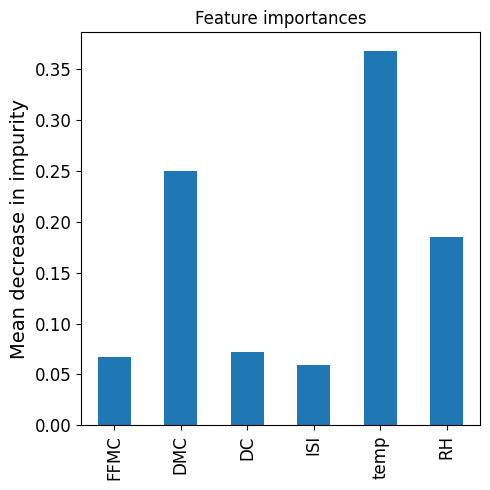

In [124]:
forest_importances = pd.Series(importances, index=fires_scaled_df.columns)

fig, ax = plt.subplots(figsize=(5,5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()